In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/ecommerceDataset.csv'

In [ ]:
import pandas as pd


1: load the dataset and display number of samples for each class label

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical


Check class distribution


In [ ]:

data = pd.read_csv(data_path, names=["Category", "Text"])

print(data.head())

print(data["Category"].value_counts())


    Category                                               Text
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...
Category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


 2 : clean it to remove stop-words and punctuation


In [ ]:
import re
import string
from nltk.corpus import stopwords
import nltk

data['Text'] = data['Text'].fillna('').astype(str)

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))

    text = " ".join([word for word in text.split() if word.lower() not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

data['Cleaned_Text'] = data['Text'].apply(clean_text)

print(data.head())


    Category                                               Text  \
0  Household  Paper Plane Design Framed Wall Hanging Motivat...   
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...   
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...   
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...   
4  Household  Incredible Gifts India Wooden Happy Birthday U...   

                                        Cleaned_Text  
0  Paper Plane Design Framed Wall Hanging Motivat...  
1  SAF Floral Framed Painting Wood 30 inch x 10 i...  
2  SAF UV Textured Modern Art Print Framed Painti...  
3  SAF Flower Print Framed Painting Synthetic 135...  
4  Incredible Gifts India Wooden Happy Birthday U...  


3 : split dataset in train and test with 30-70 ratio, ensure stratified split


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Encoded_Category'] = label_encoder.fit_transform(data['Category'])

X_train, X_test, y_train, y_test = train_test_split(
    data['Cleaned_Text'], data['Encoded_Category'], test_size=0.3, stratify=data['Encoded_Category'], random_state=42)

# Further split train into train and validation (90%-10%)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")


Training samples: 31767, Validation samples: 3530, Test samples: 15128


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

 #function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    return accuracy, precision, recall, f1


# experiment : 01 using TextVectorization with one-gram multi_hot encoding

In [ ]:
vectorizer = TextVectorization(max_tokens=10000, output_mode='multi_hot', ngrams=1)
vectorizer.adapt(X_train)

model = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)
print(f"Model 1 - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")


Epoch 1/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 52s 48ms/step - accuracy: 0.8623 - loss: 0.4640 - val_accuracy: 0.9606 - val_loss: 0.1650
Epoch 2/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.9858 - loss: 0.0656 - val_accuracy: 0.9688 - val_loss: 0.1347
Epoch 3/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.9944 - loss: 0.0265 - val_accuracy: 0.9708 - val_loss: 0.1548
Epoch 4/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.9955 - loss: 0.0175 - val_accuracy: 0.9714 - val_loss: 0.1705
Epoch 5/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 0.9697 - val_loss: 0.1781
473/473 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step
Model 1 - Accuracy: 0.9725013220518244, Precision: 0.972566418017077, Recall: 0.9725013220518244, F1 Score: 0.9724995140389263


# experiment 2 :using TextVectorization with two-gram multi_hot encoding

In [ ]:
vectorizer = TextVectorization(max_tokens=10000, output_mode='multi_hot', ngrams=2)
vectorizer.adapt(X_train)

model = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)
print(f"Model 2 - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")



Epoch 1/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 88s 88ms/step - accuracy: 0.8100 - loss: 0.5205 - val_accuracy: 0.9586 - val_loss: 0.1565
Epoch 2/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 140s 86ms/step - accuracy: 0.8211 - loss: nan - val_accuracy: 0.2346 - val_loss: nan
Epoch 3/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 142s 86ms/step - accuracy: 0.2359 - loss: nan - val_accuracy: 0.2346 - val_loss: nan
Epoch 4/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 150s 94ms/step - accuracy: 0.2363 - loss: nan - val_accuracy: 0.2346 - val_loss: nan
Epoch 5/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 135s 87ms/step - accuracy: 0.2357 - loss: nan - val_accuracy: 0.2346 - val_loss: nan
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step
Model 2 - Accuracy: 0.2343997884717081, Precision: 0.0549432608355815, Recall: 0.2343997884717081, F1 Score: 0.08902020455399774


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# experiment 3 : using TextVectorization with two-gram TF_IDF  encoding

Epoch 1/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 91s 90ms/step - accuracy: 0.8744 - loss: 0.5214 - val_accuracy: 0.9450 - val_loss: 0.2255
Epoch 2/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 138s 87ms/step - accuracy: 0.9801 - loss: 0.0958 - val_accuracy: 0.9609 - val_loss: 0.2039
Epoch 3/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 140s 84ms/step - accuracy: 0.9902 - loss: 0.0434 - val_accuracy: 0.9680 - val_loss: 0.1705
Epoch 4/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 142s 85ms/step - accuracy: 0.9948 - loss: 0.0265 - val_accuracy: 0.9683 - val_loss: 0.1682
Epoch 5/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 142s 84ms/step - accuracy: 0.9940 - loss: 0.0250 - val_accuracy: 0.9561 - val_loss: 0.2543
473/473 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step
Model 3 - Accuracy: 0.9582892649391856, Precision: 0.959810463182912, Recall: 0.9582892649391856, F1 Score: 0.9584360051802773


# Experiment 04 : LSTM + embedding


In [ ]:
vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=200)
vectorizer.adapt(X_train)

model = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Embedding(input_dim=10000, output_dim=32),
    LSTM(32),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)
print(f"Model 4 - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")


Epoch 1/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3957 - loss: 1.3218 - val_accuracy: 0.4130 - val_loss: 1.2197
Epoch 2/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4577 - loss: 1.1801 - val_accuracy: 0.5453 - val_loss: 1.0835
Epoch 3/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.5161 - loss: 1.1553 - val_accuracy: 0.4660 - val_loss: 1.2506
Epoch 4/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5020 - loss: 1.1854 - val_accuracy: 0.4439 - val_loss: 1.0483
Epoch 5/5
993/993 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5252 - loss: 1.0174 - val_accuracy: 0.7496 - val_loss: 0.6157
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Model 4 - Accuracy: 0.7498016922263353, Precision: 0.6341712844539142, Recall: 0.7498016922263353, F1 Score: 0.6837023440837974


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 # Experiment 5 : LSTM + Glove  

In [ ]:
glove_path = '/content/drive/MyDrive/datasets/glove.6B'


In [ ]:
glove_path = '/content/drive/MyDrive/datasets/glove.6B/glove.6B.100d.txt'

import os
if os.path.exists(glove_path):
    print("GloVe file found!")
else:
    print("GloVe file not found. Check the file path.")


GloVe file found!


In [ ]:
embedding_index = {}
glove_path = '/content/drive/MyDrive/datasets/glove.6B/glove.6B.100d.txt'

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vectors

print("Embedding for 'the':", embedding_index.get('the'))


Embedding for 'the': [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
import string
import re

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = " ".join([word for word in text.split() if word.lower() not in stop_words])
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    else:
        return ""

data_path = '/content/drive/MyDrive/datasets/ecommerceDataset.csv'
data = pd.read_csv(data_path, header=None, names=['Category', 'Text'])

data['Cleaned_Text'] = data['Text'].apply(clean_text)

X = data['Cleaned_Text']
y = data['Category']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=200)
vectorizer.adapt(X_train)

X_train_vect = vectorizer(X_train)
X_test_vect = vectorizer(X_test)

embedding_dim = 100
embedding_matrix = np.zeros((10000, embedding_dim))

embedding_index = {}
glove_path = '/content/drive/MyDrive/datasets/glove.6B/glove.6B.100d.txt'  # Correct path to your GloVe file
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vectors

for i, word in enumerate(vectorizer.get_vocabulary()):
    if i < 10000:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

model = tf.keras.Sequential([
    tf.keras.Input(shape=(200,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=10000, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_vect, y_train, validation_data=(X_test_vect, y_test), epochs=5, batch_size=32)

y_pred_prob = model.predict(X_test_vect)
y_pred = np.argmax(y_pred_prob, axis=-1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/5
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 386s 344ms/step - accuracy: 0.5061 - loss: 1.1471 - val_accuracy: 0.6767 - val_loss: 0.7952
Epoch 2/5
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 433s 339ms/step - accuracy: 0.6824 - loss: 0.8064 - val_accuracy: 0.7672 - val_loss: 0.6932
Epoch 3/5
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 372s 337ms/step - accuracy: 0.6924 - loss: 0.7698 - val_accuracy: 0.8605 - val_loss: 0.4887
Epoch 4/5
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 386s 341ms/step - accuracy: 0.8312 - loss: 0.5395 - val_accuracy: 0.9028 - val_loss: 0.3680
Epoch 5/5
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 381s 339ms/step - accuracy: 0.8895 - loss: 0.3903 - val_accuracy: 0.9231 - val_loss: 0.2840
473/473 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step
Accuracy: 0.9231
Precision: 0.9239
Recall: 0.9231
F1 Score: 0.9230


# Model Performance Comparison: Accuracy, Precision, Recall, and F1 Score



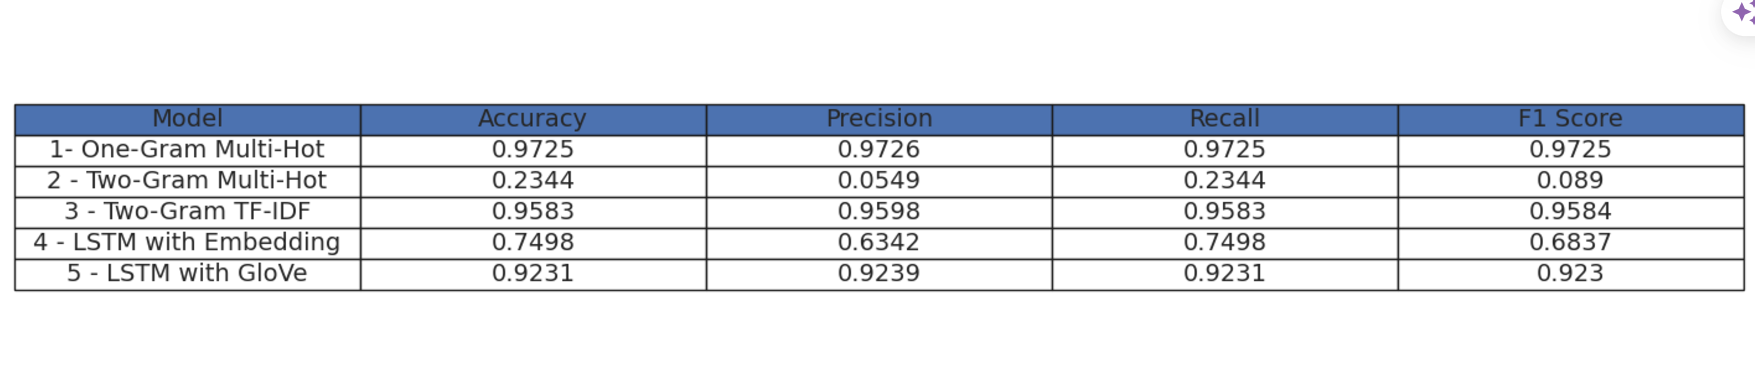

Model	               Accuracy	  Precision	 Recall	 F1 Score
One-gram Multi-hot		0.9725    0.9725     0.972   	 0.972          	         
Two-gram Multi-hot	    0.234    0.05	    0.234	   0.089
Two-gram TF-IDF	      0.958      0.959	  0.957	    0.956
LSTM with Embedding	   0.7498	   0.638	   0.74	    0.68
LSTM with GloVe  	     0.92	      0.92	  0.92	    0.923


Model 1 (One-Gram Multi-Hot Encoding) performs the best because it has the highest accuracy (0.9725) and well-balanced scores for precision, recall, and F1. Its straightforward approach works well for this dataset.